# Why embed networks?

Networks by themselves can have interesting properties, but a network is not how we traditionally organize data in machine learning. In almost any ML algorithm - whether you're using a neural network or a decision tree, whether your goal is to classify observations or to predict values using regression - you'll see data organized into a matrix, where the rows represent observations and the columns represent features, or variables. Each observation, or row of the matrix, is traditionally represented as a single point in $d$-dimensional space (if there are $d$ columns in the matrix). If you have two columns, for instance, you could represent data organized in this way on an x/y coordinate plane. The first column would represent the x-axis, and the second column would represent the y-axis.

For example, the data below is organized traditionally. On the left is the data matrix; each observation has its own row, with two features across the columns. The x-column contains the first feature for each observation, and the y-column contains the second feature for each observation. We can see the two clusters of data numerically, through the color mapping.

On the right is the same data, but plotted in Euclidean space. Each column of the data matrix gets its own axis in the plot. The x and y axis location of the $i^{th}$ point in the scatterplot is the same as the x and y values of the $i^{th}$ row of the data matrix. We can see the two clusters of data geometrically, through the location of the points.

In [1]:
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np

# make the data
centers = np.array([[-2, -2], 
                    [2, 2]])
X, labels = make_blobs(n_samples=10, cluster_std=0.5,
                  centers=centers, shuffle=False)

# convert data into a DataFrame
data = pd.DataFrame(X, columns=["x", "y"])

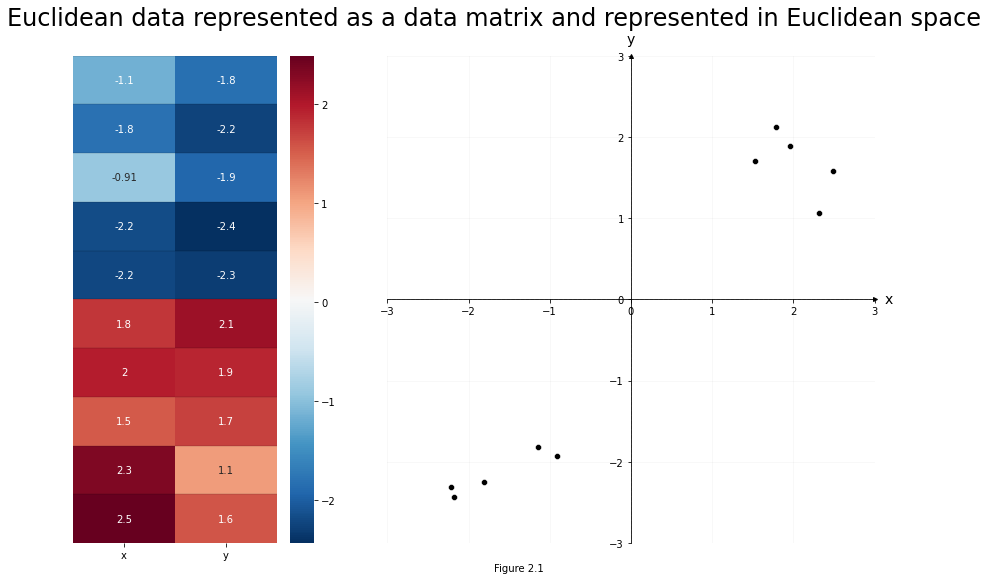

In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from graphbook_code import GraphColormap, draw_cartesian

# setup
cmap = GraphColormap("divergent", k=2).color
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(1, 3)
axm = fig.add_subplot(gs[0])
axs = fig.add_subplot(gs[1:])

# plot left
hm = sns.heatmap(data, ax=axm, yticklabels=False, 
                 cmap=cmap, annot=True, cbar=True)
hm.hlines(range(len(data)), *hm.get_xlim(), colors='k', alpha=.1)

# plot right
draw_cartesian(ax=axs)
plot = sns.scatterplot(data=data, x='x', y='y', legend=False, ax=axs, color="k")

# lines
max_ = int(data.values.max()) + 1
plot.vlines(0, -max_, max_, colors="black", lw=.9, linestyle="dashed", alpha=.2)
plot.hlines(0, -max_, max_, colors="black", lw=.9, linestyle="dashed", alpha=.2)

# ticks
plot.xaxis.set_major_locator(plt.MaxNLocator(6))
plot.yaxis.set_major_locator(plt.MaxNLocator(6))

# set axis bounds
lim = (-max_, max_)
plot.set(xlim=lim, ylim=lim)

# title, etc
plt.figtext(0.5, 0, "Figure 2.1")
plt.suptitle("Euclidean data represented as a data matrix and represented in Euclidean space", fontsize=24)
plt.tight_layout()

It's often useful for our data to be organized like this, since it opens the door to a wide variety of machine learning methods. With the data above, for example, we could use scikit-learn to perform simple K-Means Clustering to find the two clusters of observations. Below, we import scikit-learn's K-Means clustering algorithm. K-Means finds a pre-determined number of clusters in your data by setting randomly determined starting-points, and then iterating to get those points closer to the true cluster means. It outputs the community membership labels for each observation, which you can see below.

In [3]:
from sklearn.cluster import KMeans

predicted_labels = KMeans(n_clusters=2).fit_predict(X)
print("Predicted labels: ", predicted_labels)

Predicted labels:  [0 0 0 0 0 1 1 1 1 1]


Text(0.5, 0, 'Figure 2.2')

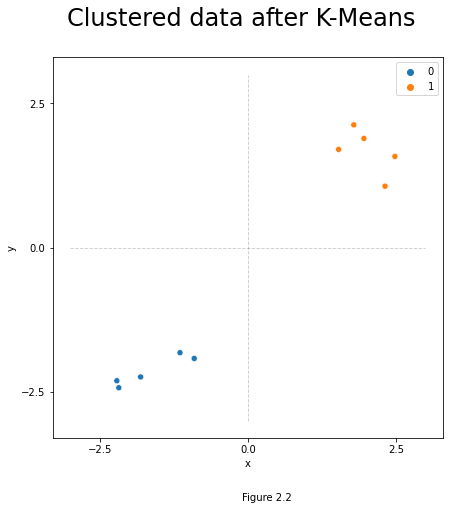

In [4]:
fig, ax = plt.subplots(figsize=(7, 7))
from graphbook_code import cmaps

# plot right
plot = sns.scatterplot(data=data, x='x', y='y', ax=ax, 
                       hue=predicted_labels, palette=cmaps["qualitative"])

# lines
plot.vlines(0, -max_, max_, colors="black", lw=.9, linestyle="dashed", alpha=.2)
plot.hlines(0, -max_, max_, colors="black", lw=.9, linestyle="dashed", alpha=.2)

# ticks
plot.xaxis.set_major_locator(plt.MaxNLocator(3))
plot.yaxis.set_major_locator(plt.MaxNLocator(3))

# title
plt.suptitle("Clustered data after K-Means", fontsize=24)
plt.figtext(0.5, 0, "Figure 2.2")

Network-valued data are different. Take the Stochastic Block Model below, shown as both a layout plot and an adjacency matrix. Say your goal is to view the nodes as particular observations, and you'd like to cluster the data in the same way you clustered the Euclidean data above. Intuitively, you'd expect to find two groups: one for the first set of heavily connected nodes, and one for the second set. Unfortunately, traditional machine learning algorithms won't work on data represented as a network: it doesn't live in the traditional rows-as-observations, columns-as-features format.

In [5]:
import networkx as nx
from graspologic.simulations import sbm
np.random.seed(1)

p = np.array([[.9, .1],
              [.1, .9]])
A, labels = sbm([25, 25], p, return_labels=True)

Text(0.5, -0.05, 'Figure 2.3')

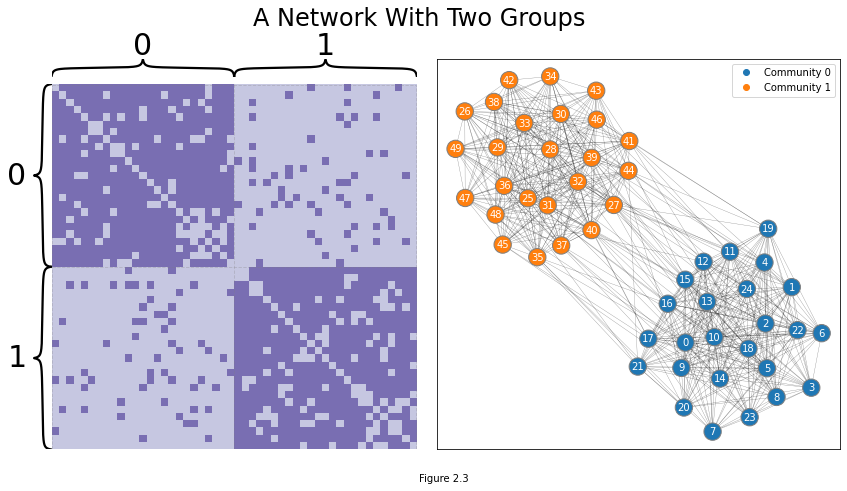

In [6]:
import graphbook_code

from graphbook_code import draw_multiplot
axs = draw_multiplot(A, labels=labels)

plt.suptitle("A Network With Two Groups", fontsize=24, y=1.05)
plt.figtext(0.5, -.05, "Figure 2.3")

You, of course, *can* make up methods which work directly on networks - algorithms which run by traversing along edges, for instance, or which use network statistics like node degree to learn, and so on - and data scientists have developed many algorithms like this. But to be able to use the entire toolbox that machine learning offers, you'd like to be able to figure out a way to *represent* networks in Euclidean space as tabular data. This is why having good embedding methods, like Spectral Embedding (which we'll learn about soon), is useful. There's another problem with networks that make embedding into lower-dimensional space useful.

## High Dimensionality of Network Data

The other problem with network data is its high dimensionality. You could view each element of an adjacency matrix as its own (binary, for unweighted networks) dimension, for instance -- although you could also make the argument that talking about dimensionality doesn't even make *sense* with network data, since it doesn't live in Euclidean space. Regardless, if you were to view the elements of the adjacency matrix as their own dimensions, you can get to a fairly unmanageable number of dimensions fairly quickly. Many dimensions can generally be unmanageable largely because of a machine learning concept called the *curse of dimensionality*, described below.

```{admonition} The Curse of Dimensionality
Our intuition often fails when observations have a lot of features -- meaning, observations that, when you think of them geometrically, are points in very high-dimensional space. 

For example, pick a point randomly in a 10,000-dimensional unit hypercube (meaning, a $1 \times 1 \times \dots \times 1$ cube, with ten thousand 1s). You can also just think of this point as a vector with 10,000 elements, each of which has a value between 0 and 1. There's a probability greater than 99.999999% that the point will be located a distance less than .001 from a border of the hypercube. This probability is only 0.4% in a unit square. This actually makes intuitive sense: if you think about measuring a lot of attributes of an object, there's a decent chance it'll be extreme in at least one of those attributes. Take yourself, for example. You're probably normal in a lot of ways, but I'm sure you can think of a part of yourself which is extreme compared to other people.

An even bigger shocker: if you pick two random points in a unit square with two dimensions, they'll be on average 0.52 units of distance away from each other. However, if you pick two random points in a unit hypercube with a million dimensions, they'll be around 408 units away from each other. This implies that, on average, any set of points that you generate from some random process when you're in high dimensions will be extremely far away from each other.

What this comes down to is that almost every point in ultra-high dimensions is extremely lonely, hugging the edge of the space it lives in, all by itself. These facts mess with many traditional machine learning methods which use relative distances, or averages (very few observations in high-dimensional space will actually be anywhere near their average!) {cite:t}`homl`
```

This is where network embedding methods come into play. Because networks represented as adjacency matrices are extremely high-dimensional, they run into many of the issues described above. Embedding, much like traditional dimensionality reduction methods in machine learning like Principle Component Analysis (PCA), allows us to move down to a more manageable number of dimensions while still preserving useful information about the network.

## Latent Estimation

The embedding methods which we'll explore the most in this book are the spectral methods. These methods pull heavily from linear algebra to keep only the information about our network which is useful - and use that information to place nodes in Euclidean space. We'll explore other methods as well. It's worth it to know a bit of linear algebra review here, particularly on concepts like eigenvectors and eigenvalues, as well as the properties of symmetric matrices. We'll guide you as clearly as possible through the math in future sections.

Spectral embedding methods in particular, which we'll talk about in the next section, will estimate an embedding called the latent position matrix. This is an $n \times d$ matrix (where this are $n$ rows, one for each node, and $d$ dimensions for each row). The latent position matrix is thus organized like a traditional data table, with nodes corresponding to observations, and you could plot the rows as points in Euclidean space.

## The Latent Position Matrix

What actually is a latent position? How can we interpret a latent position matrix?

Well, assuming you're viewing your network as some type of random dot product graph (remember that this can include SBMs, ER networks, and more), you can think of every node as being secretly associated with a position in Euclidean space. This position (relative to the positions associated with other nodes) tells you the probability that one node will have an edge with another node.

Let's call the latent position matrix, $X$. Remember that $X$ has $n$ rows (the number of nodes) and $d$ columns (the number of dimensions). Although in practice you almost never know what the latent position matrix *actually* is, you can *estimate it* by embedding your network.

We're going to cheat a bit and use an embedding method (in this case, adjacency spectral embedding) before we've discussed it, just to show what this looks like. In the next section, you'll learn how this embedding is happening, but for now, just think of it as a way to estimate the latent positions for the nodes of a network and move from network space to Euclidean space.

Below we make a network, which in this case is an SBM. From the network, we can estimate a set of latent positions, where $n=20$ rows for each node and $d=2$ dimensions. Usually when something is an estimation for something else in statistics, you put a hat over it: $\hat{X}$. We'll do that here.

In [7]:
from graspologic.simulations import sbm
from graspologic.embed import AdjacencySpectralEmbed as ASE
import numpy as np

# make a network
B = np.array([[0.8, 0.1], 
              [0.1, 0.8]])
n = [10, 10]
A, labels = sbm(n=n, p=B, return_labels=True)

# embed
ase = ASE(n_components=2)
X = ase.fit_transform(A)

Text(1, -0.05, 'Figure 2.4')

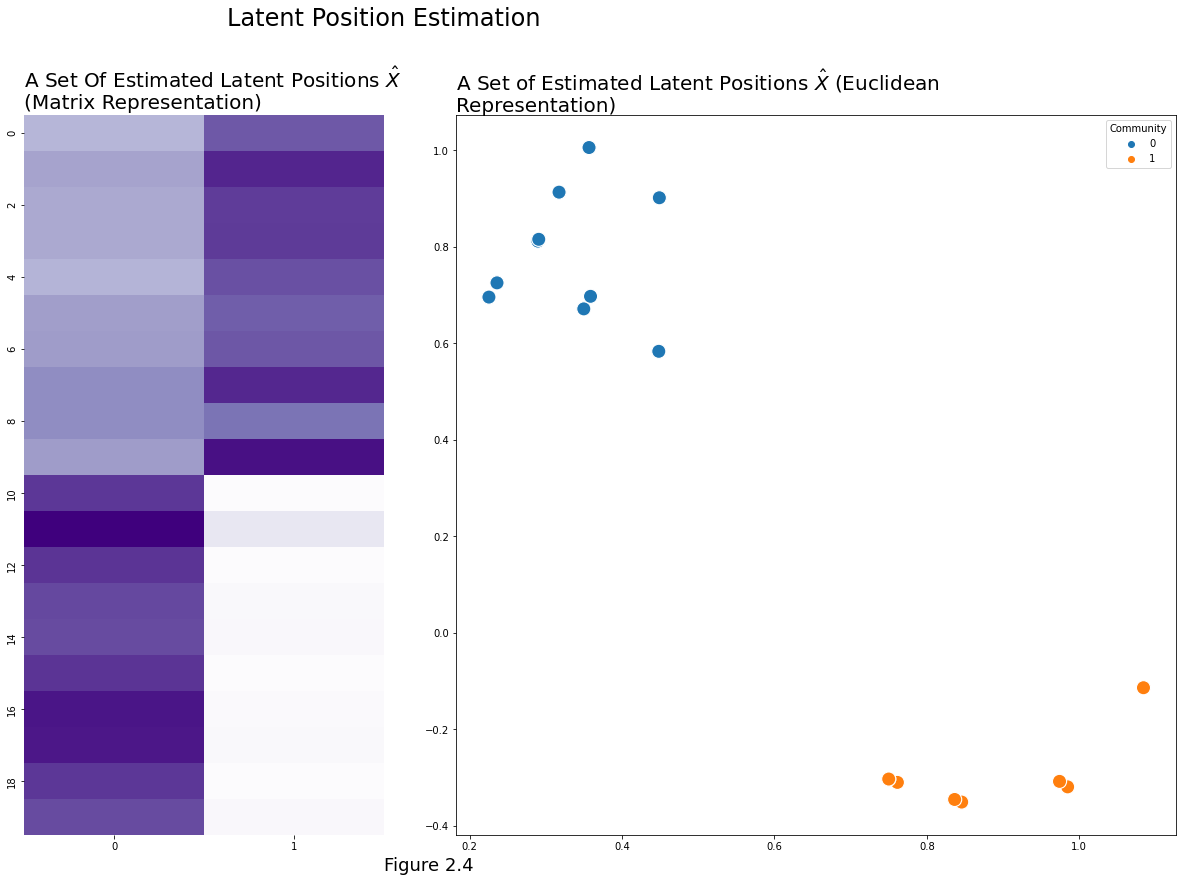

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from graphbook_code import cmaps, plot_latents

fig = plt.figure(figsize=(5, 10))
ax = fig.add_axes([0, 0, 1, 1])
cmap = cmaps["sequential"]
ax = sns.heatmap(X, cmap=cmap, cbar=False, xticklabels=1, yticklabels=2, ax=ax)
ax.set_title("A Set Of Estimated Latent Positions $\hat{X}$ \n(Matrix Representation)", 
             loc='left', fontdict={"fontsize": 20});

ax_eucl = fig.add_axes([1.2, 0, 2, 1])
plot_latents(X, labels=labels, title="A Set of Estimated Latent Positions $\hat{X}$ (Euclidean Representation)", 
             fontdict={"fontsize": 20}, s=200);

plt.suptitle("Latent Position Estimation", fontsize=24, y=1.15, x=1)
plt.figtext(1, -.05, "Figure 2.4", fontsize=18)

It's good to emphasize here that we're modeling our networks as *random dot-product graphs* (RDPGs). One implication is that we can think of a network as having some underlying probability distribution, and any specific network is one of many possible realizations of that distribution. It also means that each edge in our network has some *probability* of existing: nodes 0 and 3, for instance, may or may not have an edge. The concept of a latent position only works under the assumption that the network is drawn from an RDPG.

### Edge Probability Matrix Estimation

We mentioned before that the relative locations of latent positions tell you about edge probabilities, but it's good to be a bit more specific. If you take the dot product (or the weighted sum) of row $i$ of the latent position matrix $X$ with row $j$, you'll get the probability that nodes $i$ and $j$ have an edge between them. Incidentally, this means that the dot product between any two rows of the latent position matrix has to be bound between 0 and 1.

#### Estimating A Block Probability Matrix From The Latent Positions

Similarly, you can estimate the block probability matrix $P$ for your network using the latent positions. How would you generate $\hat{P}$ from $\hat{X}$?

Well, you'd just multiply it by its transpose: $\hat{P} = \hat{X} \hat{X}^\top$. This operation will take the dot product between every row of $\hat{X}$ and put it in the result. $(\hat{X} \hat{X}^\top)_{ij}$ will just be the dot product between rows $i$ and $j$ of the estimated latent position matrix (which is the estimated probability that nodes $i$ and $j$ will be connected). So, $\hat{X} \hat{X}^\top$ is just an estimate for the $n \times n$ block probability matrix.

Text(0.5, 0, 'Figure 2.5')

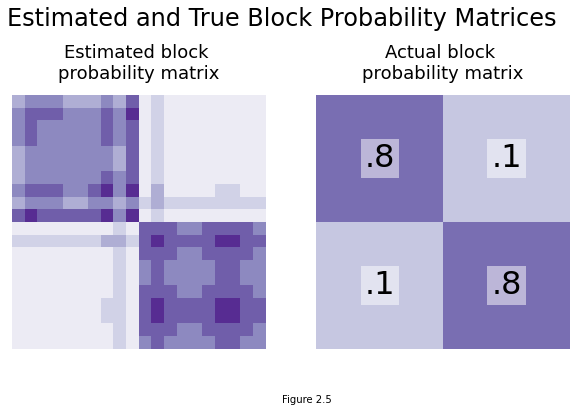

In [9]:
from graphbook_code import text


shape = (X.shape[0]//2, X.shape[0]//2)
B0 = np.full(shape, .8)
B1 = np.full(shape, .1)

# block probability matrix
B = np.block([[B0, B1],
              [B1, B0]])



from graphbook_code import heatmap

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

heatmap(X@X.T, title="Estimated block \nprobability matrix", ax=axs[0], cbar=False);
heatmap(B, title="Actual block \nprobability matrix", ax=axs[1], cbar=False)

# text
text(".8", .25, .75)
text(".8", .75, .25)
text(".1", .25, .25)
text(".1", .75, .75);

plt.suptitle("Estimated and True Block Probability Matrices", fontsize=24, y=1.1)
plt.figtext(0.5, 0, "Figure 2.5")

### Thinking About Latent Positions Geometrically

You can also think about this stuff geometrically. The dot product between any two vectors $u_i$ and $u_j$, geometrically, is their lengths multiplied together and then weighted by the cosine of the angle between them. Smaller angles have cosines close to 1, and larger angles have cosines close to 0. So, nodes whose latent positions have larger angles between them tend to have lower edge probabilities, and nodes whose latent positions have smaller angles between them tend to have higher edge probabilities. This is the core intuition you need to understand why you can find communities and do downstream inference with latent position matrices: two nodes whose latent positions are further apart will have a smaller probability of having an edge between them!

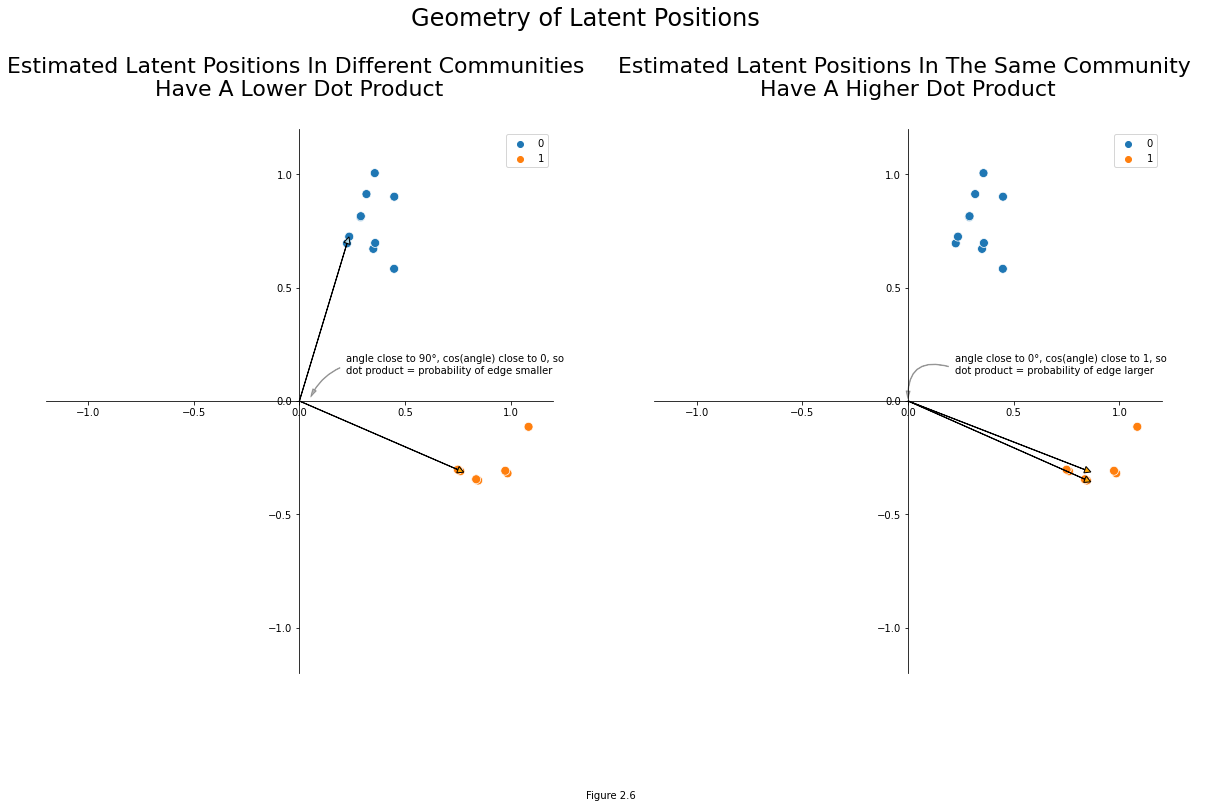

In [12]:
import matplotlib.patches as patches

fig, axs = plt.subplots(1, 2, figsize=(20, 10))


####### First Ax
# background plot
ax = axs[0]
plot = sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=labels,
    s=80,
    ax=ax,
    palette="tab10",
    color="k",
)
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])

# plot vector arrows
u_i = X[0]
u_j = X[-1]
ax.arrow(0, 0, u_i[0], u_i[1], head_width=0.03, head_length=0.03, fc='lightblue', ec='black')
ax.arrow(0, 0, u_j[0], u_j[1], head_width=0.03, head_length=0.03, fc='orange', ec='black')

# Text and text arrow
style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="k", alpha=.3)
text_arrow = patches.FancyArrowPatch((0.2, 0.15), (.05, .01), connectionstyle="arc3, rad=.2", **kw)
txt = r"""
angle close to 90°, cos(angle) close to 0, so 
dot product = probability of edge smaller
"""
ax.text(0.22, 0.07, txt)
ax.add_patch(text_arrow)

ax.set_title("Estimated Latent Positions In Different Communities \nHave A Lower Dot Product", y=1.05, fontsize=22);

####### Second Ax
ax = axs[1]
plot = sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=labels,
    s=80,
    ax=ax,
    palette="tab10",
    color="k",
)
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])

# plot vector arrows
u_i = X[-1]
u_j = X[-2]
ax.arrow(0, 0, u_j[0], u_i[1], head_width=0.03, head_length=0.03, fc='orange', ec='black')
ax.arrow(0, 0, u_j[0], u_j[1], head_width=0.03, head_length=0.03, fc='orange', ec='black')

# Text and text arrow
style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="k", alpha=.3)
text_arrow = patches.FancyArrowPatch((0.2, .15), (0, 0), connectionstyle="arc3, rad=.7", **kw)
txt = r"""
angle close to 0°, cos(angle) close to 1, so 
dot product = probability of edge larger
"""
ax.text(0.22, 0.07, txt)
ax.add_patch(text_arrow)

ax.set_title("Estimated Latent Positions In The Same Community \nHave A Higher Dot Product", y=1.05, fontsize=22);

plt.suptitle("Geometry of Latent Positions", fontsize=24, y=1.05)
plt.figtext(0.5, -.05, "Figure 2.6")

plt.savefig("/Users/alex/Dropbox/thesis_pdf/figures/fig_2-6.png", bbox_inches="tight", dpi=300)

Keep in mind that the two figures above contain *estimates* for the latent positions, not the true ones. The true latent positions would have sets of point-masses in the same location for each community, since every node in an SBM in the same community has the same latent position. There's math that shows that you get a pretty good estimate for the block probability matrix using these estimates as well. In practice, that's what you're actually doing: getting an estimate of the latent positions with spectral embedding, then using those to do more downstream tasks or estimating block probability matrices.